In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier


import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, f1_score,accuracy_score,roc_curve

from joblib import dump

import optuna
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import tensorflow as tf

In [45]:
def preprocess(df):
        # # Encode categorical features
    binary_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

    for col in binary_columns:
        df[col].replace({"Yes": 1, "No": 0}, inplace=True)

    df["gender"].replace({"Female": 1, "Male": 0}, inplace=True)
    # The customerID column is not useful as the feature is used for identification of customers.
    df.drop(["customerID"],axis=1,inplace = True)
    df.drop(["Unnamed: 0"],axis=1,inplace = True)
    cols_to_scale = ["tenure", "MonthlyCharges", "TotalCharges"]
    scaler = MinMaxScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    # Get dummy data for some of the categorical data
    df = pd.get_dummies(data = df, columns=['InternetService', 'Contract', 'PaymentMethod'])
    return df

In [46]:
# load and preprocess the test data
test_df = pd.read_csv("test.csv")
test_df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3005,0516-QREYC,Female,1,No,No,24,Yes,No,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,20.30,459.95,No
1,3006,9685-WKZGT,Male,1,No,No,14,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.95,1036.75,Yes
2,3007,6022-UGGSO,Female,1,No,No,32,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.40,2276.95,Yes
3,3008,8084-OIVBS,Female,0,No,No,11,Yes,No,No,...,No,No,No,No,One year,No,Mailed check,20.00,211.95,No
4,3009,8896-BQTTI,Male,0,No,No,1,Yes,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,25.00,25.00,No


In [47]:
test_df = preprocess(test_df)

In [48]:
test_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,1,0,0,0.323944,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1,0,1,0,0,0.183099,1,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,1,1,0,0,0.436620,1,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
3,1,0,0,0,0.140845,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4,0,0,0,0,0.000000,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,1


In [49]:
X_test = test_df.drop("Churn", axis=1)
y_test = test_df["Churn"]
y_test.value_counts()

0    2946
1    1086
Name: Churn, dtype: int64

In [50]:
type(X_test)

pandas.core.frame.DataFrame

In [51]:
type(y_test)

pandas.core.series.Series

In [52]:
train_df = pd.read_csv("synthatic_data.csv")
train_df.drop(["Unnamed: 0"],axis=1,inplace = True)
train_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,1,0,0,0.647887,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,0,0,0,0,0.225352,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0.000000,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,1,1,0,0,1.000000,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,1,0.000000,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [53]:
X = train_df.drop("Churn", axis=1)
y = train_df["Churn"]
y.value_counts()

0    74170
1    25830
Name: Churn, dtype: int64

In [54]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

# perform random undersampling
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# print the class distribution after undersampling
print('Resampled class distribution:', Counter(y))

Resampled class distribution: Counter({0: 25830, 1: 25830})


In [65]:
X =X.to_numpy()

y = y.to_numpy()

# CNN

In [65]:


def create_model(num_filters, kernel_size, pool_size, dense_units, learning_rate, l2_weight):
    model = Sequential()
    model.add(Conv1D(num_filters, kernel_size, activation='relu', input_shape=(X.shape[1], 1), kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
def objective(trial):
    num_filters = trial.suggest_int('num_filters', 32, 128, step=32)
    kernel_size = trial.suggest_int('kernel_size', 3, 7)
    pool_size = trial.suggest_int('pool_size', 2, 5)
    dense_units = trial.suggest_int('dense_units', 16, 64, step=16)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    l2_weight = trial.suggest_loguniform('l2_weight', 1e-6, 1e-3)

    model = create_model(num_filters=num_filters, kernel_size=kernel_size, pool_size=pool_size, dense_units=dense_units, learning_rate=learning_rate, l2_weight=l2_weight)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es, reduce_lr], verbose=0)
        _, score = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(score)

    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params

[I 2023-05-01 12:24:08,341] A new study created in memory with name: no-name-01ed1c50-5596-43fe-82cc-1a79ad81a548
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_19660\3300205321.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_19660\3300205321.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_weight = trial.suggest_loguniform('l2_weight', 1e-6, 1e-3)
[I 2023-05-01 12:38:12,933] Trial 0 finished with value: 0.894426691532135 and parameters: {'num_filters': 128, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 48, 'learning_rat

Best trial:
  Value: 0.894426691532135
  Params: 
    num_filters: 128
    kernel_size: 6
    pool_size: 2
    dense_units: 48
    learning_rate: 0.0004284050344599286
    l2_weight: 1.1769711585511664e-05


In [59]:
import matplotlib.pyplot as plt
def plot_val_acc_loss(history):     
    #plot the training and validation accuracy and loss at each epoch     
    loss = history.history['loss']     
    val_loss = history.history['val_loss']     
    epochs = range(1, len(loss) + 1)     
    plt.plot(epochs, loss, 'y', label='Training loss')     
    plt.plot(epochs, val_loss, 'r', label='Validation loss')     
    plt.title('Training and validation loss')     
    plt.xlabel('Epochs')     
    plt.ylabel('Loss')     
    plt.legend()     
    plt.show()     
    acc = history.history['accuracy']     
    val_acc = history.history['val_accuracy']     
    plt.plot(epochs, acc, 'y', label='Training acc')     
    plt.plot(epochs, val_acc, 'r', label='Validation acc')     
    plt.title('Training and validation accuracy')     
    plt.xlabel('Epochs')     
    plt.ylabel('Accuracy')     
    plt.legend()     
    plt.show()

In [66]:
model = create_model(128,6,2,48,0.0004284050344599286,1.1769711585511664e-05)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 21, 128)           896       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 flatten_9 (Flatten)         (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 48)                61488     
                                                                 
 dense_19 (Dense)            (None, 1)                 49        
                                                     

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)


In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
history = model.fit(X, 
                    y, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[es, reduce_lr])


Epoch 1/50
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3708 - accuracy: 0.8290 - val_loss: 0.3610 - val_accuracy: 0.8341 - lr: 4.2841e-04
Epoch 2/50
2500/2500 [==============================] - 18s 7ms/step - loss: 0.3627 - accuracy: 0.8311 - val_loss: 0.3613 - val_accuracy: 0.8328 - lr: 4.2841e-04
Epoch 3/50
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3611 - accuracy: 0.8330 - val_loss: 0.3584 - val_accuracy: 0.8336 - lr: 4.2841e-04
Epoch 4/50
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3603 - accuracy: 0.8335 - val_loss: 0.3584 - val_accuracy: 0.8357 - lr: 4.2841e-04
Epoch 5/50
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3589 - accuracy: 0.8346 - val_loss: 0.3572 - val_accuracy: 0.8346 - lr: 4.2841e-04
Epoch 6/50
2500/2500 [==============================] - 15s 6ms/step - loss: 0.3596 - accuracy: 0.8339 - val_loss: 0.3581 - val_accuracy: 0.8328 - lr: 4.2841e-04
Epoch 7/50
2500/2500 [======

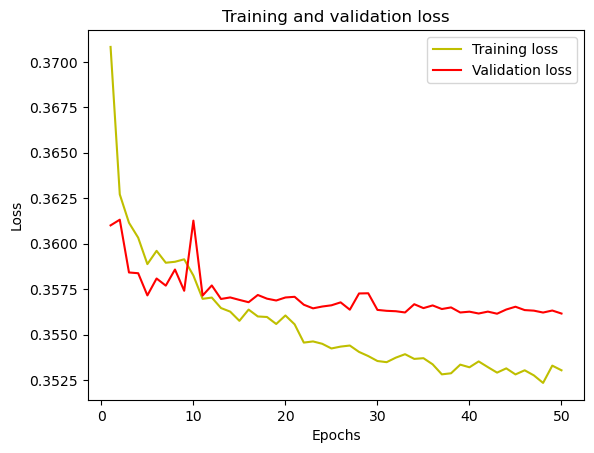

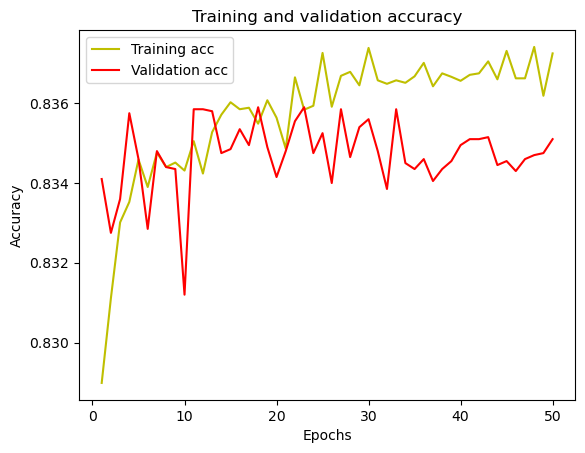

In [68]:
plot_val_acc_loss(history)

In [70]:
def create_model_v2(num_filters, kernel_size, pool_size, dense_units, learning_rate, l2_weight):
    model = Sequential()
    model.add(Conv1D(num_filters, kernel_size, activation='relu', input_shape=(X.shape[1], 1), kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(num_filters*2, kernel_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(dense_units*2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [71]:
model2 = create_model_v2(128,6,2,48,0.0004284050344599286,1.1769711585511664e-05)

model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 21, 128)           896       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 10, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 5, 256)            196864    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 2, 256)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 256)            0         
                                                                 
 flatten_10 (Flatten)        (None, 512)             

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
history2 = model2.fit(X, 
                    y, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[es, reduce_lr])

Epoch 1/100
3125/3125 [==============================] - 24s 8ms/step - loss: 0.3545 - accuracy: 0.8363 - val_loss: 0.3520 - val_accuracy: 0.8372 - lr: 2.1420e-04
Epoch 2/100
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3543 - accuracy: 0.8363 - val_loss: 0.3511 - val_accuracy: 0.8371 - lr: 2.1420e-04
Epoch 3/100
3125/3125 [==============================] - 24s 8ms/step - loss: 0.3546 - accuracy: 0.8364 - val_loss: 0.3511 - val_accuracy: 0.8367 - lr: 2.1420e-04
Epoch 4/100
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3545 - accuracy: 0.8364 - val_loss: 0.3507 - val_accuracy: 0.8377 - lr: 2.1420e-04
Epoch 5/100
3125/3125 [==============================] - 22s 7ms/step - loss: 0.3537 - accuracy: 0.8369 - val_loss: 0.3519 - val_accuracy: 0.8367 - lr: 2.1420e-04
Epoch 6/100
3125/3125 [==============================] - 25s 8ms/step - loss: 0.3536 - accuracy: 0.8367 - val_loss: 0.3504 - val_accuracy: 0.8374 - lr: 2.1420e-04
Epoch 7/100
3125/3125 

3125/3125 [==============================] - 23s 7ms/step - loss: 0.3427 - accuracy: 0.8410 - val_loss: 0.3363 - val_accuracy: 0.8450 - lr: 1.0710e-04
Epoch 52/100
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3426 - accuracy: 0.8418 - val_loss: 0.3354 - val_accuracy: 0.8443 - lr: 1.0710e-04
Epoch 53/100
3125/3125 [==============================] - 22s 7ms/step - loss: 0.3432 - accuracy: 0.8412 - val_loss: 0.3356 - val_accuracy: 0.8429 - lr: 1.0710e-04
Epoch 54/100
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3426 - accuracy: 0.8417 - val_loss: 0.3361 - val_accuracy: 0.8447 - lr: 1.0710e-04
Epoch 55/100
3125/3125 [==============================] - 22s 7ms/step - loss: 0.3427 - accuracy: 0.8419 - val_loss: 0.3349 - val_accuracy: 0.8443 - lr: 1.0710e-04
Epoch 56/100
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3428 - accuracy: 0.8425 - val_loss: 0.3344 - val_accuracy: 0.8449 - lr: 1.0710e-04
Epoch 57/100
3125/3125 [=====

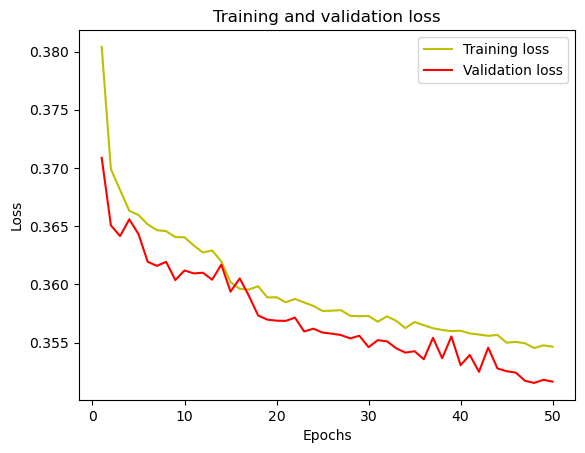

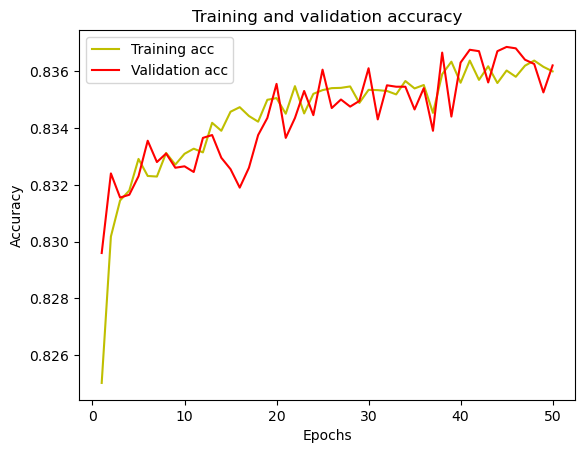

In [73]:
plot_val_acc_loss(history2)

In [40]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [46]:
# predict probabilities for the test set
probs = rf.predict_proba(X_test)

# set a higher threshold for the positive class
threshold = 0.2
y_pred = (probs[:,1] > threshold).astype(int)

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [47]:
# y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))
print("f1_score_value: ", f1_score(y_test, y_pred))
print("precision_value: ", precision_score(y_test, y_pred))
print("recall_value: ", recall_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.72      0.79      2946
           1       0.48      0.71      0.58      1086

    accuracy                           0.72      4032
   macro avg       0.68      0.72      0.68      4032
weighted avg       0.77      0.72      0.73      4032

f1_score_value:  0.5755662829558114
precision_value:  0.48226509023024267
recall_value:  0.7136279926335175


In [13]:
gbm = xgb.XGBClassifier().fit(X,y)
y_pred = gbm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2946
           1       0.53      0.65      0.58      1086

    accuracy                           0.75      4032
   macro avg       0.69      0.72      0.70      4032
weighted avg       0.77      0.75      0.76      4032



# Hyperparameter Tuning

# RF

In [10]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = True
    oob_score = False
    random_state = 42
    n_jobs = -1
   
    rf_params = {
        'n_estimators': n_estimators,
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'bootstrap': bootstrap,
        'oob_score': oob_score,
        'random_state': random_state,
        'n_jobs': n_jobs
    }
    
    model = RandomForestClassifier(**rf_params)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
#     all_f1_scores = []
#     all_precisions = []
    all_recalls = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)

        y_pred = (model.predict_proba(X_val)[:, 1] > 0.5).astype(int)
        
        recall_value = recall_score(y_val, y_pred)

        all_recalls.append(recall_value)
        
    avg_recall = np.mean(all_recalls)

    return avg_recall

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)



[I 2023-05-02 10:56:56,754] A new study created in memory with name: no-name-50e008bc-5324-4964-acce-82b83a1c483b
[I 2023-05-02 10:57:08,377] Trial 0 finished with value: 0.8339527680991097 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8339527680991097.
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

In [11]:
print("Best trial:")
trial = study.best_trial
print("  Recall: {:.4f}".format(trial.value))
# print("  Precision: {:.4f}".format(trial.avg_precision))
# print("  Recall: {:.4f}".format(np.mean(all_recalls)))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_rf_params = study.best_params


Best trial:
  Recall: 0.8423
  Params: 
    n_estimators: 100
    criterion: entropy
    max_depth: 5
    min_samples_split: 18
    min_samples_leaf: 5
    max_features: log2


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds for cross validation
k_folds = 5

# Initialize a random forest classifier
rfc = RandomForestClassifier(**best_rf_params)

# Initialize a KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize a list to store accuracy scores for each fold
accuracy_scores = []
F1_scores = []
recall_scores = []

# Perform k-fold cross validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    # Split the data into training and testing sets for the current fold
    X_train, y_train = X[train_idx], y[train_idx]
    X_test2, y_test2 = X[test_idx], y[test_idx]
    
    # Fit the random forest classifier to the training data
    rfc.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = rfc.predict(X_test2)
    
    # Calculate accuracy score for the current fold
    accuracy = accuracy_score(y_test2, y_pred)
    accuracy_scores.append(accuracy)
    
    f1 = f1_score(y_test2, y_pred)
    F1_scores.append(f1)
    
    recall_value = recall_score(y_test2, y_pred)
    recall_scores.append(recall_value)
    
    # Print the accuracy score for the current fold
    print(f'Fold {fold+1} accuracy score: {accuracy:.4f}')
    print(f'Fold {fold+1} f1 score: {f1:.4f}')
    print(f'Fold {fold+1} recall score: {recall_value:.4f}')

# Print the average accuracy score across all folds
print(f'Average accuracy score: {np.mean(accuracy_scores):.4f}')
print(f'Average F1 score: {np.mean(F1_scores):.4f}')
print(f'Average Recall score: {np.mean(recall_scores):.4f}')

Fold 1 accuracy score: 0.8114
Fold 1 f1 score: 0.8163
Fold 1 recall score: 0.8355
Fold 2 accuracy score: 0.8046
Fold 2 f1 score: 0.8096
Fold 2 recall score: 0.8349
Fold 3 accuracy score: 0.8075
Fold 3 f1 score: 0.8157
Fold 3 recall score: 0.8358
Fold 4 accuracy score: 0.8008
Fold 4 f1 score: 0.8078
Fold 4 recall score: 0.8408
Fold 5 accuracy score: 0.8103
Fold 5 f1 score: 0.8144
Fold 5 recall score: 0.8441
Average accuracy score: 0.8069
Average F1 score: 0.8128
Average Recall score: 0.8382


In [16]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2946
           1       0.52      0.70      0.60      1086

    accuracy                           0.75      4032
   macro avg       0.70      0.73      0.71      4032
weighted avg       0.78      0.75      0.76      4032



C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [17]:
print("Accuracy_value: ", accuracy_score(y_test, y_pred))
print("f1_score_value: ", f1_score(y_test, y_pred))
print("recall_value: ", recall_score(y_test, y_pred))

Accuracy_value:  0.7472718253968254
f1_score_value:  0.5970739422696719
recall_value:  0.6952117863720073


In [30]:
from joblib import dump

In [31]:
# Save the trained model to a file
dump(rfc, 'rfc_model.joblib')

['rfc_model.joblib']

# Logistic Regression

In [66]:
def objective(trial):
    # Define the hyperparameters to be tuned by Optuna
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'C': trial.suggest_loguniform('C', 1e-4, 100),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    }
    
    # Train and evaluate the logistic regression model using cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
    all_scores = []
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = LogisticRegression(**params)
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict(X_val)
        recall = recall_score(y_val, y_pred)
        all_scores.append(recall)
    
    return np.mean(all_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2023-05-08 00:02:26,455] A new study created in memory with name: no-name-fe3de7fe-1968-473b-8016-16fe864e8984
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
[I 2023-05-08 00:02:27,183] Trial 0 finished with value: 0.840340689121177 and parameters: {'penalty': 'l2', 'C': 1.5407813926369216, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.840340689121177.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4,

[I 2023-05-08 00:02:47,140] Trial 14 finished with value: 0.8469221835075494 and parameters: {'penalty': 'l2', 'C': 0.00010599686609619408, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 14 with value: 0.8469221835075494.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
[I 2023-05-08 00:02:47,950] Trial 15 finished with value: 0.8420828493999226 and parameters: {'penalty': 'l2', 'C': 0.0031366501282036694, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 14 with value: 0.8469221835075494.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
[I 2023-05-08 00:02:55,189] Trial 29 finished with value: 0.8501742160278745 and parameters: {'penalty': 'l2', 'C': 0.0009619133519012619, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 29 with value: 0.8501742160278745.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
[I 2023-05-08 00:02:55,918] Trial 30 finished with value: 0.843321718931475 and parameters: {'pe

[I 2023-05-08 00:03:04,964] Trial 43 finished with value: 0.8606271777003484 and parameters: {'penalty': 'l2', 'C': 0.0002833201004559872, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 43 with value: 0.8606271777003484.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
[I 2023-05-08 00:03:07,623] Trial 44 finished with value: 0.862137049941928 and parameters: {'penalty': 'l2', 'C': 0.0002475221055606221, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 44 with value: 0.862137049941928.
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\803267002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna

In [67]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

lr_best_params = trial.params

lr_clf = LogisticRegression(**lr_best_params)
#cross_validate(X_train, y, rf_clf)
lr_clf.fit(X, y)

Best trial:
  Value: 0.8648857917150601
  Params: 
    penalty: l2
    C: 0.00018869812691420546
    fit_intercept: False
    solver: saga


LogisticRegression(C=0.00018869812691420546, fit_intercept=False, solver='saga')

In [23]:
lr_y_pred = lr_clf.predict(X_test)
print(classification_report(y_test,lr_y_pred))
print("Accuracy_value: ", accuracy_score(y_test, lr_y_pred))
print("f1_score_value: ", f1_score(y_test, lr_y_pred))
print("recall_value: ", recall_score(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2946
           1       0.53      0.65      0.58      1086

    accuracy                           0.75      4032
   macro avg       0.70      0.72      0.70      4032
weighted avg       0.77      0.75      0.76      4032

Accuracy_value:  0.7527281746031746
f1_score_value:  0.5847563515201999
recall_value:  0.6464088397790055


C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [32]:
# Save the trained model to a file
dump(lr_clf, 'lr_model.joblib')

['lr_model.joblib']

# XGBoost

In [24]:
def objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    xgb_clf = xgb.XGBClassifier(**xgb_params)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
    all_scores = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        xgb_clf.fit(X_tr, y_tr)

        y_pred = xgb_clf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        all_scores.append(auc)

    avg_auc = np.mean(all_scores)

    return avg_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)



[I 2023-05-02 11:50:32,802] A new study created in memory with name: no-name-1a8cf713-f341-4730-bc0b-552a91248ad5
[I 2023-05-02 11:50:59,759] Trial 0 finished with value: 0.8913384350369139 and parameters: {'n_estimators': 434, 'max_depth': 4, 'learning_rate': 0.018669861667079755, 'min_child_weight': 6, 'subsample': 0.6847512489578057, 'colsample_bytree': 0.13458245283546158}. Best is trial 0 with value: 0.8913384350369139.
[I 2023-05-02 11:51:56,038] Trial 1 finished with value: 0.8892609948996453 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.07195537597200029, 'min_child_weight': 8, 'subsample': 0.7925141151690677, 'colsample_bytree': 0.5100843600605112}. Best is trial 0 with value: 0.8913384350369139.
[I 2023-05-02 11:52:25,935] Trial 2 finished with value: 0.8918080022014754 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.010090201142491442, 'min_child_weight': 4, 'subsample': 0.12255479540540522, 'colsample_bytree': 0.3844729435

[I 2023-05-02 12:04:10,181] Trial 25 finished with value: 0.8911400654297456 and parameters: {'n_estimators': 223, 'max_depth': 3, 'learning_rate': 0.02184770132544344, 'min_child_weight': 10, 'subsample': 0.23788639867045652, 'colsample_bytree': 0.5883756449095491}. Best is trial 6 with value: 0.8925369112106031.
[I 2023-05-02 12:04:32,155] Trial 26 finished with value: 0.892166708708733 and parameters: {'n_estimators': 370, 'max_depth': 2, 'learning_rate': 0.057423803121460545, 'min_child_weight': 10, 'subsample': 0.2808135248395204, 'colsample_bytree': 0.7065166247157124}. Best is trial 6 with value: 0.8925369112106031.
[I 2023-05-02 12:04:53,823] Trial 27 finished with value: 0.8922192050856961 and parameters: {'n_estimators': 368, 'max_depth': 2, 'learning_rate': 0.060021436658141074, 'min_child_weight': 9, 'subsample': 0.28513976337485225, 'colsample_bytree': 0.6436229935159062}. Best is trial 6 with value: 0.8925369112106031.
[I 2023-05-02 12:05:01,483] Trial 28 finished with va

In [25]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

xgb_best_params = trial.params
xgb_clf = xgb.XGBClassifier(**xgb_best_params)
xgb_clf.fit(X, y, verbose=0)

Best trial:
  Value: 0.8925369112106031
  Params: 
    n_estimators: 186
    max_depth: 4
    learning_rate: 0.05095498627162097
    min_child_weight: 3
    subsample: 0.6720624526948957
    colsample_bytree: 0.6254818459470338


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6254818459470338, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05095498627162097,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=186, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
xgb_y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test,xgb_y_pred))
print("Accuracy_value: ", accuracy_score(y_test, xgb_y_pred))
print("f1_score_value: ", f1_score(y_test, xgb_y_pred))
print("recall_value: ", recall_score(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2946
           1       0.53      0.65      0.58      1086

    accuracy                           0.75      4032
   macro avg       0.70      0.72      0.70      4032
weighted avg       0.77      0.75      0.76      4032

Accuracy_value:  0.751984126984127
f1_score_value:  0.5843724023275145
recall_value:  0.647329650092081


In [33]:
# Save the trained model to a file
dump(xgb_clf, 'xgb_model.joblib')

['xgb_model.joblib']

# KNN

In [15]:
def objective(trial):
    knn_params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("weights", ['uniform', 'distance']),
        "p": trial.suggest_categorical("p", [1, 2, 3])
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
    all_scores = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        knn_clf = KNeighborsClassifier(**knn_params)
        knn_clf.fit(X_tr, y_tr)

        y_pred = knn_clf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        all_scores.append(auc)

    avg_auc = np.mean(all_scores)

    return avg_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)



[I 2023-05-02 22:56:47,594] A new study created in memory with name: no-name-3514d92a-2ed7-43c2-bc37-2dce7632b39b
[I 2023-05-02 22:56:54,468] Trial 0 finished with value: 0.8718983559228878 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8718983559228878.
[I 2023-05-02 22:58:07,245] Trial 1 finished with value: 0.8579243524585017 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 3}. Best is trial 0 with value: 0.8718983559228878.
[I 2023-05-02 22:58:10,549] Trial 2 finished with value: 0.875357548664254 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 22:58:13,481] Trial 3 finished with value: 0.8740152751342236 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 22:58:21,155] Trial 4 finished with value: 0.855184618628997 and parameters: {'n_neighbors': 6, 'weights': 'uni

[I 2023-05-02 23:06:48,488] Trial 40 finished with value: 0.8635948754543129 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 23:06:52,477] Trial 41 finished with value: 0.875357548664254 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 23:06:55,878] Trial 42 finished with value: 0.875357548664254 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 23:06:59,291] Trial 43 finished with value: 0.8740152751342236 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 23:07:02,464] Trial 44 finished with value: 0.8732964232468495 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.875357548664254.
[I 2023-05-02 23:07:05,475] Trial 45 finished wi

In [16]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

knn_best_params = trial.params
knn_clf = KNeighborsClassifier(**knn_best_params)
knn_clf.fit(X, y)

Best trial:
  Value: 0.875357548664254
  Params: 
    n_neighbors: 15
    weights: uniform
    p: 2


KNeighborsClassifier(n_neighbors=15)

In [17]:
knn_y_pred = knn_clf.predict(X_test)
print(classification_report(y_test,knn_y_pred))
print("Accuracy_value: ", accuracy_score(y_test, knn_y_pred))
print("f1_score_value: ", f1_score(y_test, knn_y_pred))
print("recall_value: ", recall_score(y_test, knn_y_pred))

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2946
           1       0.49      0.70      0.58      1086

    accuracy                           0.73      4032
   macro avg       0.68      0.72      0.69      4032
weighted avg       0.77      0.73      0.74      4032

Accuracy_value:  0.7261904761904762
f1_score_value:  0.5779816513761468
recall_value:  0.6961325966850829


In [18]:
# Save the trained model to a file
dump(knn_clf, 'knn_model.joblib')

['knn_model.joblib']

# SVM

In [ ]:
def objective(trial):
    # Define the hyperparameters to be tuned by Optuna
    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 100),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 100),
        'degree': trial.suggest_int('degree', 2, 5),
        'coef0': trial.suggest_uniform('coef0', -1, 1)
    }
    
    # Train and evaluate the SVC model using cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)
    all_scores = []
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = SVC(**params, probability=True)
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        all_scores.append(auc)
    
    return np.mean(all_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
svm_clf = SVC(**best_params, probability=True)
svm_clf.fit(X, y)

[I 2023-04-30 16:06:32,347] A new study created in memory with name: no-name-051ed0f4-b092-4a6a-85f4-a60572c0f62c
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_19636\4219271124.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'C': trial.suggest_loguniform('C', 1e-4, 100),
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_19636\4219271124.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 100),
C:\Users\Apiseg\AppData\Local\Temp\ipykernel_19636\4219271124.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds for cross validation
k_folds = 5

# Initialize a random forest classifier
svm_clf = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)


# Initialize a KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize a list to store accuracy scores for each fold
accuracy_scores = []
F1_scores = []
recall_scores = []

# Perform k-fold cross validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    # Split the data into training and testing sets for the current fold
    X_train, y_train = X[train_idx], y[train_idx]
    X_test2, y_test2 = X[test_idx], y[test_idx]
    
    # Fit the random forest classifier to the training data
    svm_clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = svm_clf.predict(X_test2)
    
    # Calculate accuracy score for the current fold
    accuracy = accuracy_score(y_test2, y_pred)
    accuracy_scores.append(accuracy)
    
    f1 = f1_score(y_test2, y_pred)
    F1_scores.append(f1)
    
    recall_value = recall_score(y_test2, y_pred)
    recall_scores.append(recall_value)
    
    # Print the accuracy score for the current fold
    print(f'Fold {fold+1} accuracy score: {accuracy:.4f}')
    print(f'Fold {fold+1} f1 score: {f1:.4f}')
    print(f'Fold {fold+1} recall score: {recall_value:.4f}')

# Print the average accuracy score across all folds
print(f'Average accuracy score: {np.mean(accuracy_scores):.4f}')
print(f'Average F1 score: {np.mean(F1_scores):.4f}')
print(f'Average Recall score: {np.mean(recall_scores):.4f}')

Fold 1 accuracy score: 0.8100
Fold 1 f1 score: 0.8150
Fold 1 recall score: 0.8343
Fold 2 accuracy score: 0.8034
Fold 2 f1 score: 0.8081
Fold 2 recall score: 0.8317
Fold 3 accuracy score: 0.8093
Fold 3 f1 score: 0.8172
Fold 3 recall score: 0.8360
Fold 4 accuracy score: 0.8015
Fold 4 f1 score: 0.8081
Fold 4 recall score: 0.8396
Fold 5 accuracy score: 0.8108
Fold 5 f1 score: 0.8146
Fold 5 recall score: 0.8431
Average accuracy score: 0.8070
Average F1 score: 0.8126
Average Recall score: 0.8370


In [43]:
svm_y_pred = svm_clf.predict(X_test)
print(classification_report(y_test,svm_y_pred))
print("Accuracy_value: ", accuracy_score(y_test, svm_y_pred))
print("f1_score_value: ", f1_score(y_test, svm_y_pred))
print("recall_value: ", recall_score(y_test, svm_y_pred))

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2946
           1       0.52      0.68      0.59      1086

    accuracy                           0.75      4032
   macro avg       0.70      0.73      0.70      4032
weighted avg       0.77      0.75      0.76      4032

Accuracy_value:  0.7470238095238095
f1_score_value:  0.5906902086677367
recall_value:  0.6777163904235728


In [44]:
# Save the trained model to a file
dump(svm_clf, 'svm_model.joblib')

['svm_model.joblib']

# Stacked Ensemble

In [59]:
# Get the predictions from the CNN model
cnn_predictions = cnn_model.predict(X_test)
cnn_predictions = [round(x[0]) for x in cnn_predictions]

# Get the predictions from the other models
rf_predictions = rfc.predict(X_test)
knn_predictions = knn_clf.predict(X_test)
svm_predictions = svm_clf.predict(X_test)
xgb_predictions = xgb_clf.predict(X_test)
lr_predictions = lr_clf.predict(X_test)

126/126 [==============================] - 0s 2ms/step


C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [69]:
# Combine the predictions into a new dataframe
predictions = np.column_stack((cnn_predictions,knn_predictions,rf_predictions,svm_predictions, xgb_predictions, lr_predictions))

# Define the meta model
meta_model = LogisticRegression()

# Fit the meta model
meta_model.fit(predictions, y_test)

# Get the final predictions from the meta model
final_predictions = meta_model.predict(predictions)

# Calculate the accuracy of the stacking classifier
accuracy = accuracy_score(y_test, final_predictions)
print("Accuracy of the stacking classifier:", accuracy)
print("Ensemble F1:", f1_score(y_test, final_predictions))
print("Ensemble Recall:", recall_score(y_test, final_predictions))

Accuracy of the stacking classifier: 0.7653769841269841
Ensemble F1: 0.5367286973555339
Ensemble Recall: 0.5046040515653776


In [71]:
# Save the trained model to a file
dump(meta_model, 'stacked_ensemble_model.joblib')

['stacked_ensemble_model.joblib']

In [52]:
from pathlib import Path
# Load the json file that contains the model's structure
f = Path("cnn_model_structure.json")
model_structure = f.read_text()

from tensorflow.keras.models import model_from_json
# Recreate the Keras model object from the json data
cnn_model = model_from_json(model_structure)

# Re-load the model's trained weights
cnn_model.load_weights("cnn_model_weights.h5")

In [ ]:
# Set the io_device option to '/job:localhost'
options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')

# Load the SavedModel with the specified options
model = tf.saved_model.load('path/to/saved_model', options=options)

In [15]:
# Load the json file that contains the model's structure
from tensorflow.keras.models import model_from_json
from joblib import load
from pathlib import Path

f = Path("cnn_model_structure.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
cnn_model = model_from_json(model_structure)

# Re-load the model's trained weights
cnn_model.load_weights("cnn_model_weights.h5")

rfc_clf = load('rfc_model.joblib')
    
knn_clf = load('knn_model.joblib')
  
svm_clf = load('svm_model.joblib')

xgb_clf = load('xgb_model.joblib')
   
lr_clf = load('lr_model.joblib')
 
meta_model = load('stacked_ensemble_model.joblib')


In [29]:
model = KerasClassifier(cnn_model)

C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\1565497736.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(cnn_model)


In [59]:
cnn_predictions = cnn_model.predict(X_test)
cnn_predictions = [round(x[0]) for x in cnn_predictions]
rf_predictions = rfc_clf.predict(X_test)
knn_predictions = knn_clf.predict(X_test)
svm_predictions = svm_clf.predict(X_test)
xgb_predictions = xgb_clf.predict(X_test)
lr_predictions = lr_clf.predict(X_test)
predictions = np.column_stack((cnn_predictions,knn_predictions,rf_predictions,svm_predictions, xgb_predictions, lr_predictions))

#     # Get the final predictions from the meta model
final_predictions = meta_model.predict_proba(predictions)

    # Combine the predictions into a new dataframe
#     predictions = np.column_stack((cnn_predictions,knn_predictions,rf_predictions,svm_predictions, xgb_predictions, lr_predictions))

#     # Get the final predictions from the meta model
#     final_predictions = meta_model.predict(predictions)


126/126 [==============================] - 0s 3ms/step


C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [60]:
# predict probabilities
pred_prob1 = rfc_clf.predict_proba(X_test)
pred_prob2 = knn_clf.predict_proba(X_test)
pred_prob3 = svm_clf.predict_proba(X_test)
pred_prob4 = xgb_clf.predict_proba(X_test)
pred_prob5 = lr_clf.predict_proba(X_test)
# pred_prob6 = cnn_model.predict_proba(X_test)

y_pred_prob = cnn_model.predict(X_test)
pred_prob6 = y_pred_prob.flatten()

    # Combine the predictions into a new dataframe
predictions = np.column_stack((cnn_predictions,knn_predictions,rf_predictions,svm_predictions, xgb_predictions, lr_predictions))

#     # Get the final predictions from the meta model
pred_prob7 = meta_model.predict_proba(predictions)



C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


 34/126 [=======>......................] - ETA: 0s

C:\Users\Apiseg\anaconda3\envs\churn\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


126/126 [==============================] - 0s 3ms/step


In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6, pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, pred_prob7[:,1], pos_label=1)
#fpr8, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)

In [20]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [21]:
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score5 = roc_auc_score(y_test, pred_prob5[:,1])
auc_score6 = roc_auc_score(y_test, pred_prob6)
auc_score7 = roc_auc_score(y_test, pred_prob7[:,1])

In [22]:

# print classifier name and AUC score
print("Random Forest :", auc_score1)
print("KNN      :", auc_score2)
print("SVM:", auc_score3)
print("XGBoost       :", auc_score4)
print("Logistic Regression:", auc_score5)
print("CNN      :", auc_score6)
print("Ensembled           :", auc_score7)
plt.style.use('seaborn')

Random Forest : 0.8064557367170142
KNN      : 0.7883022395757147
SVM: 0.7836177030627415
XGBoost       : 0.8028673583058592
Logistic Regression: 0.8038639651229811
CNN      : 0.7314676766199197
Ensembled           : 0.764501981023681


C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\4065633896.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


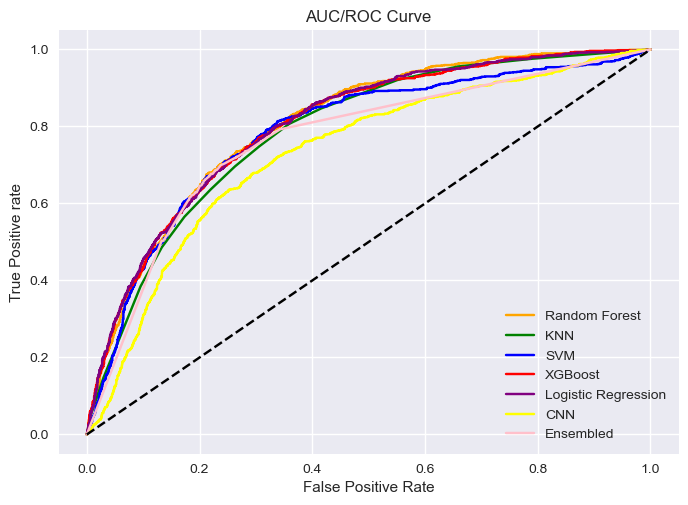

In [23]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='-',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='-',color='green', label='KNN')
plt.plot(fpr3, tpr3, linestyle='-',color='blue', label='SVM')
plt.plot(fpr4, tpr4, linestyle='-',color='red', label='XGBoost')
plt.plot(fpr5, tpr5, linestyle='-',color='purple', label='Logistic Regression')
plt.plot(fpr6, tpr6, linestyle='-',color='yellow', label='CNN')
plt.plot(fpr7, tpr7, linestyle='-',color='pink', label='Ensembled')

plt.plot(p_fpr, p_tpr, linestyle='--', color='black')

# title
plt.title('AUC/ROC Curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [61]:
# calculate recall scores
recall_score1 = recall_score(y_test, np.round(pred_prob1[:, 1]))
recall_score2 = recall_score(y_test, np.round(pred_prob2[:, 1]))
recall_score3 = recall_score(y_test, np.round(pred_prob3[:, 1]))
recall_score4 = recall_score(y_test, np.round(pred_prob4[:, 1]))
recall_score5 = recall_score(y_test, np.round(pred_prob5[:, 1]))
recall_score6 = recall_score(y_test, np.round(pred_prob6))
recall_score7 = recall_score(y_test, np.round(pred_prob7[:, 1]))

In [62]:
# print classifier name and recall score
print("Random Forest :", recall_score1)
print("KNN      :", recall_score2)
print("SVM:", recall_score3)
print("XGBoost       :", recall_score4)
print("Logistic Regression:", recall_score5)
print("CNN      :", recall_score6)
print("Ensembled           :", recall_score7)
plt.style.use('seaborn')

Random Forest : 0.6952117863720073
KNN      : 0.6961325966850829
SVM: 0.6712707182320442
XGBoost       : 0.647329650092081
Logistic Regression: 0.6464088397790055
CNN      : 0.5994475138121547
Ensembled           : 0.509208103130755


C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\472990115.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [63]:
# calculate f1 scores
f1_score1 = f1_score(y_test, np.round(pred_prob1[:, 1]))
f1_score2 = f1_score(y_test, np.round(pred_prob2[:, 1]))
f1_score3 = f1_score(y_test, np.round(pred_prob3[:, 1]))
f1_score4 = f1_score(y_test, np.round(pred_prob4[:, 1]))
f1_score5 = f1_score(y_test, np.round(pred_prob5[:, 1]))
f1_score6 = f1_score(y_test, np.round(pred_prob6))
f1_score7 = f1_score(y_test, np.round(pred_prob7[:, 1]))

In [64]:
# print classifier name and recall score
print("Random Forest :", f1_score1)
print("KNN      :", f1_score2)
print("SVM:", f1_score3)
print("XGBoost       :", f1_score4)
print("Logistic Regression:", f1_score5)
print("CNN      :", f1_score6)
print("Ensembled           :", f1_score7)
plt.style.use('seaborn')

Random Forest : 0.5970739422696719
KNN      : 0.5779816513761468
SVM: 0.5955882352941178
XGBoost       : 0.5843724023275145
Logistic Regression: 0.5847563515201999
CNN      : 0.5431789737171464
Ensembled           : 0.5403028822667317


C:\Users\Apiseg\AppData\Local\Temp\ipykernel_26520\4058476294.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
